In [55]:
import json
import osmnx as ox
from osmnx import distance as oxdist
import matplotlib.pyplot as plt

MultiDiGraph with 3865 nodes and 9111 edges


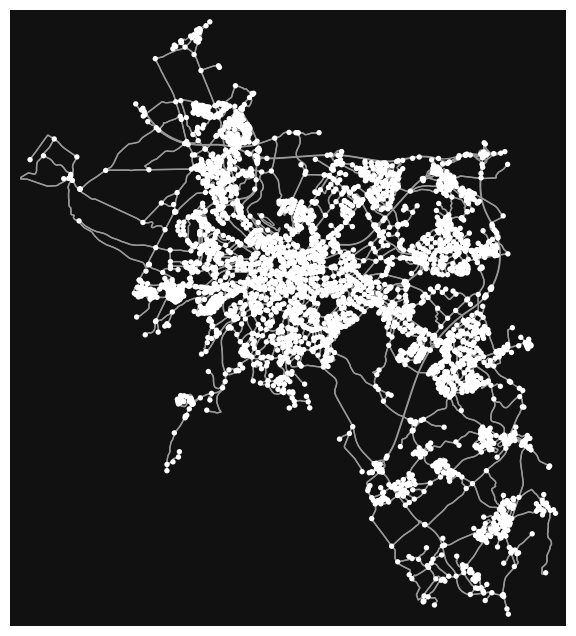

In [56]:
# Extract city graph (for drivable roads)
city_name = "aachen"
G = ox.graph_from_place(city_name, network_type="drive")

print(G)
ox.plot_graph(G) 
plt.show()


Map Data is usually stored in the WGS84 format (World Geodetic System 1984) which describes coordinates via latidude and longitude e.g.
$$( \underbrace{52.5163° N}_{\text{Latitude North}}, \underbrace{13.3777° E}_{\text{Longitude East}}, \underbrace{34 m}_{\text{Height}})$$


<p align="center" style="background-color: #4d4a43; padding: 10px;">
  <img src="https://www.maptive.com/wp-content/uploads/2021/01/Latitude_and_Longitude_of_the_Earth.svg" alt="Latitude and Longitude">
</p>
 
As these are descriptions of angles on the earth's ellipsoid, they are not directly suitable for simple distance calculations:
Therefore, for geometric computations (like distances, areas, buffering), it is easier to work with a CRS (Coordinate Reference System) that projects the curved surface of the earth onto a flat plane.

A common choice is UTM (Universal Transverse Mercator), which expresses positions in meters within a given zone. This way, distances between points can be obtained by straightforward Euclidean formulas.

In [57]:
# Convert from WGS84 to CRS via UTM
G = ox.project_graph(G) 

# Add length attribute (in meters) to each road segment/edge
oxdist.add_edge_lengths(G)
# Convert graph into table (GeoDataFrames from GeoPandas)
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# List of nodes in format [NodeID (int): (x (float),y (float)]
nodes = {
    int(nid): {"x": float(row["x"]), "y": float(row["y"])}
    for nid, row in nodes_gdf[["x","y"]].iterrows()
}
# List of edges in format [u (NodeID/int), v (NodeID/int), length (float), highway (string), oneway (bool)]
edges = (
    edges_gdf.reset_index()
    .assign(oneway=lambda df: df["oneway"].fillna(False))
    [["u","v","length","highway","oneway"]]
    .to_dict(orient="records")
)

with open(f"{city_name}.json","w") as f:
    json.dump({"nodes": nodes, "edges": edges}, f, separators=(",",":"))
